<a href="https://colab.research.google.com/github/shvms/covid19-nlp/blob/master/baseline/fake_news_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
import re
import random
import time
import json
from typing import List, Tuple, Dict, Set

In [ ]:
!pip install tensorflow===1.15.0

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
tf.compat.v1.disable_eager_execution()

In [17]:
with open("stopwords.txt", encoding="utf-8") as f:
  stopwords = set(f.read().split("\n"))
print(len(stopwords))

668


In [21]:
with open("cov19_keywords.txt", encoding="utf-8") as f:
  keywords = f.read().split("\n")
print(len(keywords))

270


In [71]:
def plot_graphs(history, metric):
  plt.plot(history.history[f'{metric}'])
  plt.plot(history.history[f'val_{metric}'])
  plt.xlabel('#Epochs')
  plt.ylabel(metric)
  plt.legend([metric, f'val_{metric}'])
  plt.show()

In [7]:
df = pd.read_csv("recovery-news-data.csv", encoding="utf-8")

In [8]:
df.head()

,news_id,url,publisher,publish_date,author,title,image,body_text,news_guard_score,mbfc_level,political_bias,country,reliability
0,0,https://www.nytimes.com/article/what-is-corona...,The New York Times,2020-01-21,"['Knvul Sheikh', 'Roni Caryn Rabin']",The Coronavirus: What Scientists Have Learned ...,https://static01.nyt.com/images/2020/03/12/sci...,\r\nA novel respiratory virus that originated ...,100.0,High,Left,USA,1
1,1,https://www.npr.org/2020/01/22/798392172/chine...,National Public Radio (NPR),2020-01-22,['Emily Feng'],Chinese Health Officials: More Die From Newly ...,https://media.npr.org/include/images/facebook-...,Chinese Health Officials: More Die From Newly ...,100.0,Very high,Center,USA,1
2,2,https://www.theverge.com/2020/1/23/21078457/co...,The Verge,2020-01-23,['Nicole Wetsman'],Everything you need to know about the coronavirus,https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...,Public health experts around the globe are scr...,100.0,High,Left-center,USA,1
3,3,https://www.worldhealth.net/news/novel-coronav...,WorldHealth.Net,2020-01-24,[],Novel Coronavirus Cases Confirmed To Be Spreading,https://www.worldhealth.net/media/original_ima...,The first two coronavirus cases in Europe have...,30.0,Low,NaN,USA,0
4,4,https://www.theverge.com/2020/1/24/21080845/co...,The Verge,2020-01-24,"['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...",Coronavirus disrupts the world: updates on the...,https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...,"A new coronavirus appeared in Wuhan, China, at...",100.0,High,Left-center,USA,1


# Preprocessing

In [13]:
def remove_stopwords(text: str, stopwords: Set[str]) -> str:
  return ' '.join(word for word in text.split(" ") if word not in stopwords)

In [22]:
"""
Removing extra characters along with words mixed with digits & HTML tags as well
Example: he120llo
Note: Words which are special COVID-19 keywords will not be removed. This list
of keywords are drawn from TweetsCOV19 dataset (https://data.gesis.org/tweetscov19/)
"""
pat = r'([A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*)'
def remove_nonsense_words(text: str):
  words = text.split(" ")
  for i in range(len(words)):
    if words[i] in keywords:
      continue
    words[i] = re.sub(pat, '', words[i])
    words[i] = re.sub(r'<!--?.*?-->', '', words[i])
    words[i] = re.sub(r'[\W|\d]+', ' ', words[i])
  
  return ' '.join(word for word in words if word != '')

print(remove_nonsense_words("hello this is cov19 speaking hel11oo3"))

hello this is cov19 speaking


In [23]:
"""
Condense three or more repetitive letters into one.
Example: "diiieeee" => "die"
"""
def condense(text, rep_size=3):
  """
  text: string data to filter
  rep_size: >= repetitive letters
  """
  return re.sub('(.)\\1{'+ str(rep_size-1) +',}', r'\1', text)

print(condense("diiieeee"))

die


In [38]:
"""
Segments data into two parts: training data & test data
in shuffled manner.
"""
def segmentData(sentences, labels, training_portion):
  train_size = int(len(sentences) * training_portion)
  coupled_data = [(sentences[i], labels[i]) for i in range(len(sentences))]
  random.seed(time.time())
  random.shuffle(coupled_data)

  train_sentences, train_labels = [], []
  for i in range(train_size):
   train_sentences.append(coupled_data[i][0])
   train_labels.append(coupled_data[i][1])

  test_sentences, test_labels = [], []
  for i in range(train_size, len(sentences)):
    test_sentences.append(coupled_data[i][0])
    test_labels.append(coupled_data[i][1])
  
  return train_sentences, train_labels, test_sentences, test_labels

# Title & body text

In [102]:
sentences, labels = [], []
for index, row in df.iterrows():
  sentences.append(f"{row['title'].lower()} {row['body_text'].lower()}")
  labels.append(row['reliability'])

AttributeError: ignored

## Preprocessing

In [43]:
for i in range(len(sentences)):
  sentences[i] = remove_nonsense_words(condense(sentences[i]))

In [45]:
print(sentences[0])

The Coronavirus  What Scientists Have Learned So Far  A novel respiratory virus that originated in Wuhan  China  last December has spread to six continents  Hundreds of thousands have been infected  at least   people have died and the spread of the coronavirus was called a pandemic by the World Health Organization in March Much remains unknown about the virus  including how many people may have very mild or asymptomatic infections  and whether they can transmit the virus  The precise dimensions of the outbreak are hard to know Here s what scientists have learned so far about the virus and the outbreak What is a coronavirus Coronaviruses are named for the spikes that protrude from their surfaces  resembling a crown or the sun s corona  They can infect both animals and people  and can cause illnesses of the respiratory tract At least four types of coronaviruses cause very mild infections every year  like the common cold  Most people get infected with one or more of these viruses at some 

In [25]:
training_portion = 0.8

In [46]:
train_sentences, train_labels, test_sentences, test_labels = segmentData(sentences, labels, training_portion)

print(f"Total articles: {len(sentences)}")
print(f"Train size: {train_size}")
print(f"Total positive labels percentage: {(sum(labels)/len(labels)) * 100}%")
print(f"Total train positive labels percentage: {(sum(train_labels)/len(train_labels)) * 100}%")

Total articles: 2029
Train size: 1623
Total positive labels percentage: 67.22523410547068%
Total train positive labels percentage: 67.09796672828097%


##Setting up Tokenizer & hyperparameters

In [66]:
num_words = 10000
oov_token = "<oov>"
trunc_type = "post"
padding_type = "post"
max_length = 300
embedding_dim = 300
lstm_dim = 64
memory_units = 64
dense_units1 = 32
dense_units2 = 1
dropout_rate = 0.2

In [48]:
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length,
                                       padding=padding_type, truncating=trunc_type)

In [50]:
with open("word_index.json", 'w') as f:
  json.dump(word_index, f)

In [51]:
print(train_sequences[0])
print(len(train_sequences[0]))
print(train_padded_sequences[0])
print(len(train_padded_sequences[0]))
print(type(train_padded_sequences[0]))

[30, 74, 7, 420, 1046, 16, 83, 7462, 157, 101, 41, 11, 74, 7, 4, 420, 1046, 16, 293, 3754, 2, 2327, 105, 7, 6, 4561, 2, 83, 23, 345, 36, 59, 376, 576, 5, 2, 150, 105, 163, 2, 56, 433, 15, 2, 637, 157, 2, 83, 9, 904, 65, 237, 7, 62, 916, 11, 38, 5, 1091, 49, 54, 60, 36, 38, 39, 230, 174, 287, 2, 637, 7851, 4, 185, 381, 191, 25, 5, 1, 218, 905, 2, 218, 3, 870, 174, 101, 7, 2, 83, 49, 17, 43, 379, 30, 101, 163, 2, 56, 433, 2, 83, 9, 1091, 4562, 310, 2, 158, 4, 174, 101, 650, 3, 450, 228, 600, 462, 2, 125, 459, 26, 5, 2, 3755, 794, 87, 3, 299, 1016, 5, 2, 6553, 1046, 1744, 189, 6, 759, 5614, 3, 1871, 2, 294, 949, 4, 547, 791, 847, 838, 9, 1670, 362, 301, 31, 2, 4562, 310, 11, 6, 848, 105, 2486, 827, 5, 2, 159, 7852, 838, 9, 370, 23, 25, 265, 4, 2, 83, 9, 332, 1763, 354, 18, 189, 8, 310, 10, 169, 3, 2613, 3, 2, 662, 362, 949, 53, 1513, 66, 760, 421, 266, 3, 1106, 633, 801, 5433, 28, 5848, 2803, 2021, 147, 2, 444, 848, 105, 827, 4, 2, 4562, 310, 11, 838, 25, 135, 22, 35, 133, 1630, 4, 31, 2,

In [52]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length,
                                      padding=padding_type, truncating=trunc_type)

In [53]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [67]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=num_words, output_dim=lstm_dim, input_length=max_length),
  tf.keras.layers.LSTM(memory_units),
  # tf.keras.layers.Dropout(rate=dropout_rate),
  tf.keras.layers.Dense(dense_units1, activation='relu'),
  tf.keras.layers.Dropout(rate=dropout_rate),
  tf.keras.layers.Dense(dense_units2, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 64)           640000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 675,137
Trainable params: 675,137
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
# training
num_epochs = 30
history = model.fit(train_padded_sequences, train_labels, epochs=num_epochs,
                    validation_data=(test_padded_sequences, test_labels),
                    batch_size=64)

Train on 1623 samples, validate on 406 samples
Epoch 1/30
1623/1623 [==============================] - 16s 10ms/sample - loss: 0.6574 - acc: 0.6642 - val_loss: 0.6239 - val_acc: 0.6773
Epoch 2/30
1623/1623 [==============================] - 14s 9ms/sample - loss: 0.6138 - acc: 0.6710 - val_loss: 0.6012 - val_acc: 0.6773
Epoch 3/30
1623/1623 [==============================] - 14s 9ms/sample - loss: 0.5706 - acc: 0.7104 - val_loss: 0.6182 - val_acc: 0.6872
Epoch 4/30
1623/1623 [==============================] - 14s 9ms/sample - loss: 0.4913 - acc: 0.8534 - val_loss: 0.5751 - val_acc: 0.6897
Epoch 5/30
1623/1623 [==============================] - 14s 9ms/sample - loss: 0.2960 - acc: 0.8940 - val_loss: 0.6315 - val_acc: 0.7340
Epoch 6/30
1623/1623 [==============================] - 14s 9ms/sample - loss: 0.1734 - acc: 0.9187 - val_loss: 0.7537 - val_acc: 0.7488
Epoch 7/30
1623/1623 [==============================] - 14s 9ms/sample - loss: 0.1157 - acc: 0.9427 - val_loss: 0.7806 - val_acc: 

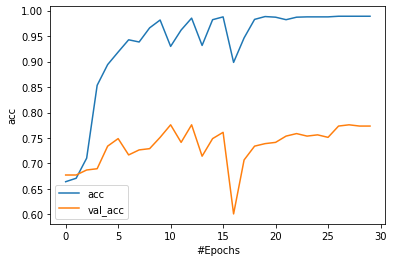

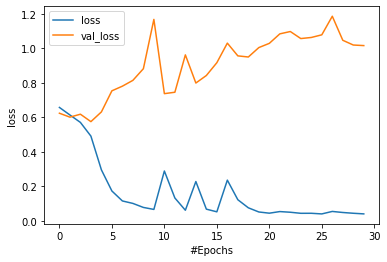

In [72]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [87]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=num_words, output_dim=16, input_length=max_length),
  tf.keras.layers.LSTM(16),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dropout(rate=dropout_rate),
  tf.keras.layers.Dense(dense_units2, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 16)           160000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_19 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
history2 = model.fit(train_padded_sequences, train_labels, epochs=num_epochs,
                    validation_data=(test_padded_sequences, test_labels),
                    batch_size=64)

Train on 1623 samples, validate on 406 samples
Epoch 1/30
1623/1623 [==============================] - 14s 9ms/sample - loss: 0.0096 - acc: 0.9975 - val_loss: 1.6440 - val_acc: 0.7833
Epoch 2/30
 576/1623 [=========>....................] - ETA: 8s - loss: 0.0044 - acc: 0.9983

KeyboardInterrupt: ignored

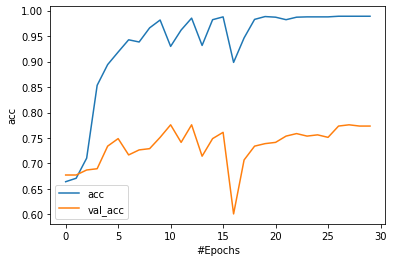

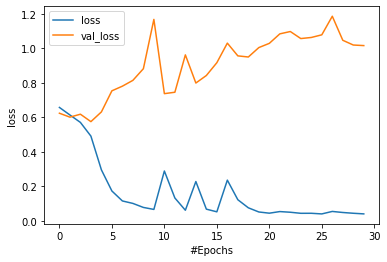

In [75]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [89]:
import pickle

In [91]:
with open('lstm_baseline.model.json', 'w') as f:
  f.write(model.to_json())

model.save_weights('model.lstm.h5')

with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Using model

In [105]:
def predict(texts, model, tokenizer) -> bool:
  """
  Predicts reliability based on baseline LSTM model.
  """

  texts = [text.lower() for text in texts]
  processed_texts = [remove_nonsense_words(condense(text)) for text in texts]

  texts_sequences = tokenizer.texts_to_sequences(texts)
  texts_padded_sequences = pad_sequences(texts_sequences, maxlen=max_length,
                                        padding=padding_type, truncating=trunc_type)

  prediction = model.predict(texts_padded_sequences)
  return prediction

In [107]:
predict(["Coronavirus is taking a serious toll on people's mental health",
         "United States of America is facing very high cases of coronavirus as community spreads broadens.",
         "There is still no vaccine available of Coronavirus as of now.",
         "A fully functional and safe vaccine of coronavirus has been developed and it will soon be available to masses.",
         "France announced a coronavirus vaccine this weekend."], model, tokenizer)

array([[0.21260685],
       [0.95933735],
       [0.95933735],
       [0.00824797],
       [0.2126069 ]], dtype=float32)